# Mental Health in the Tech Industry: Demographic Analysis, Comparison of Rates with NIMH Rates

## Introduction

Mental health is a critical part of every person's wellbeing. Today, it's common  that one's work environment contributes significantly to mental wellness or illness. This notebook seeks to explore how rates of mental illness in the tech industry may compare to National Institute of Mental Health (NIMH)'s reported rates. This analysis is enhanced with demographic data.

This notebook works with Kaggle's Mental Health in the Tech Industry dataset.

## Imports

In [1]:
import pandas as pd
import sqlite3 as sql
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import requests
from datasets import load_dataset
from scipy.stats import binom
from matplotlib.ticker import FuncFormatter
from statsmodels.stats.proportion import proportion_confint

## Load Survey Data

In [2]:
# Path to the SQLite database
dataset = './mental_health.sqlite'
# Connect to the SQLite database
conn = sql.connect(dataset)
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in the database:")
print(tables)

Tables in the database:
       name
0    Answer
1  Question
2    Survey


The dataset has 3 tables: Answer, Question, and Survey. Answer holds AnswerText (each respondent's response), SurveyID (year of survey), UserID (unique identifier for each respondent), and QuestionID (unique identifier for each question). Question holds questiontext (content of each question as presented to responders) and QuestionID. Survey holds SurveyID (year the survey was given) and Description (statement of survey year).

## Create Dataframe

In [3]:
df=pd.read_sql("SELECT Answer.SurveyID, Answer.UserID, Answer.QuestionID, Answer.AnswerText, Question.questiontext FROM Answer JOIN Question ON Answer.QuestionID = Question.questionid;", conn)

print(f"Loaded Mental Health data frame with shape {df.shape[0]:,d} x {df.shape[1]:,d}.")
df.head()

Loaded Mental Health data frame with shape 236,898 x 5.


,SurveyID,UserID,QuestionID,AnswerText,questiontext
0,2014,1,1,37,What is your age?
1,2014,2,1,44,What is your age?
2,2014,3,1,32,What is your age?
3,2014,4,1,31,What is your age?
4,2014,5,1,31,What is your age?


## EDA -- Demographics of Responders

### Number of Responders

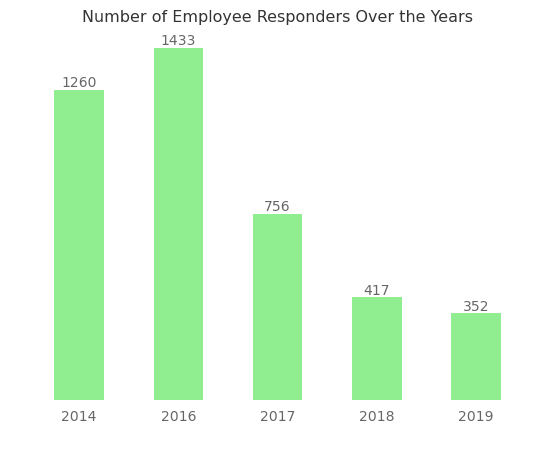

In [4]:
query = """
    SELECT
    SurveyID,
    COUNT(DISTINCT UserID) AS Responders
FROM Answer
GROUP BY SurveyID;
"""
responders_per_survey = pd.read_sql(query, conn).astype({"Responders": int})

barplot = responders_per_survey.plot.bar(x='SurveyID',y='Responders', color = 'lightgreen')
barplot.legend_.remove()  # Remove the legend

plt.title('Number of Employee Responders Over the Years', fontsize=11.5, alpha=0.8)
plt.ylabel(' ')
plt.xlabel(' ')
plt.xticks(rotation=0, ha='center', alpha=0.6)
sns.despine(left=True, bottom=True, right=True, top=True) # Remove spines

plt.gca().tick_params(axis='y', which='both', left=False, labelleft=False)
plt.gca().tick_params(axis='x', which='both', left=False, bottom=False)

for p in barplot.patches:
    if p.get_height() != 0:  # Skip annotating zero values
        barplot.annotate(format(p.get_height(), '.0f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         fontsize=10, alpha=0.6,  # Adjust font size as needed
                         xytext=(0, 5), 
                         textcoords='offset points')

plt.show()

2016 was the year with by far the greatest number of responses at 1,433. 2019 had the fewest responders, with only 352. In total over all years of the survey, there were 4,218 responders.

What demographics were these responders a member of?

### Country of Residence

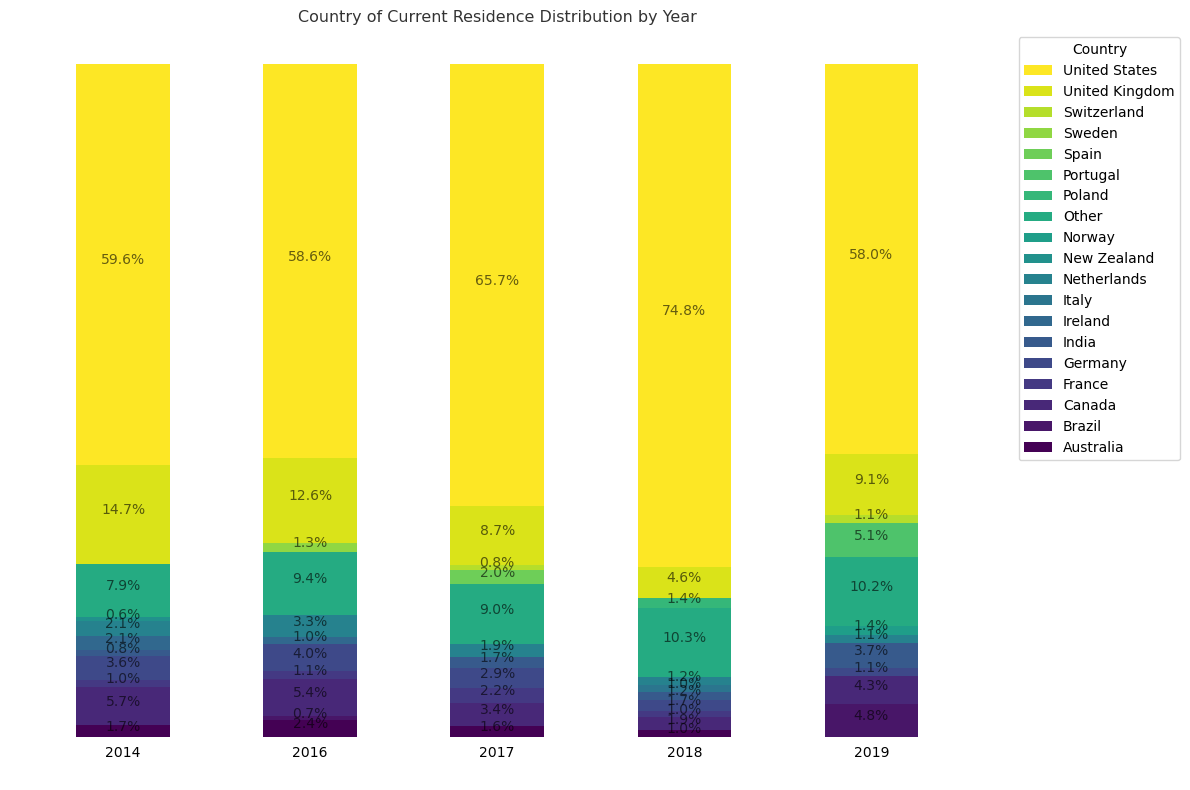

In [5]:
query = """
WITH CountryCounts AS (
    SELECT 
        SurveyID,
        CASE
            WHEN LOWER(AnswerText) LIKE '%united states%' THEN 'United States'
            ELSE AnswerText
        END AS Country,
        COUNT(*) AS ResponseCount
    FROM Answer
    WHERE QuestionID = 3
    GROUP BY 
        SurveyID,
        CASE
            WHEN LOWER(AnswerText) LIKE '%united states%' THEN 'United States'
            ELSE AnswerText
        END
),
RankedCountries AS (
    SELECT 
        SurveyID,
        Country,
        ResponseCount,
        ROW_NUMBER() OVER (PARTITION BY SurveyID ORDER BY ResponseCount DESC) AS Rank
    FROM CountryCounts
),
TopCountries AS (
    SELECT 
        SurveyID,
        Country,
        ResponseCount
    FROM RankedCountries
    WHERE Rank <= 10
),
AggregatedCountries AS (
    SELECT 
        SurveyID,
        'Other' AS Country,
        SUM(ResponseCount) AS ResponseCount
    FROM RankedCountries
    WHERE Rank > 10
    GROUP BY SurveyID
)

SELECT 
    SurveyID,
    Country,
    ResponseCount
FROM TopCountries
UNION ALL
SELECT 
    SurveyID,
    Country,
    ResponseCount
FROM AggregatedCountries
ORDER BY SurveyID, ResponseCount DESC;

"""

df = pd.read_sql(query, conn)

# Pivot the DataFrame to get the percentage for each year and country
pivot_df = df.pivot_table(index='SurveyID', columns='Country', values='ResponseCount', aggfunc='sum').fillna(0)

# Calculate the percentage of each country by year
pivot_df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Create the stacked bar chart
ax = pivot_df_percentage.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')

# Add labels to the bars
for c in ax.containers:
    labels = [f'{v:.1f}%' if v > 0 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', padding=3, alpha=0.6)

# Customize the plot
sns.despine(left=True, bottom=True, right=True, top=True)  # Remove spines
plt.gca().tick_params(axis='y', which='both', left=False, labelleft=False)
plt.gca().tick_params(axis='x', which='both', left=False, bottom=False)
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Country of Current Residence Distribution by Year', fontsize=11.5, alpha=0.8)
plt.xticks(rotation=0)  # Rotate x-axis labels to make them more readable

# Customize the legend
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', reverse=True)  # Reverse the order

# Display the chart
plt.tight_layout()
plt.show()

I started by counting the number of responses for each unique country across all years of the survey. Next, I ranked these countries by their response counts to identify the most frequently mentioned. I selected the top 10 countries with the highest response counts for detailed representation. All other countries (those not in the top 10) were aggregated into an "other" category.

Each year, responders currenlty living in the United States made up more than half of the total responses, from a low of 58% in 2019 to a high of 74.8% in 2018.

### Gender Identity

<Figure size 1200x800 with 0 Axes>

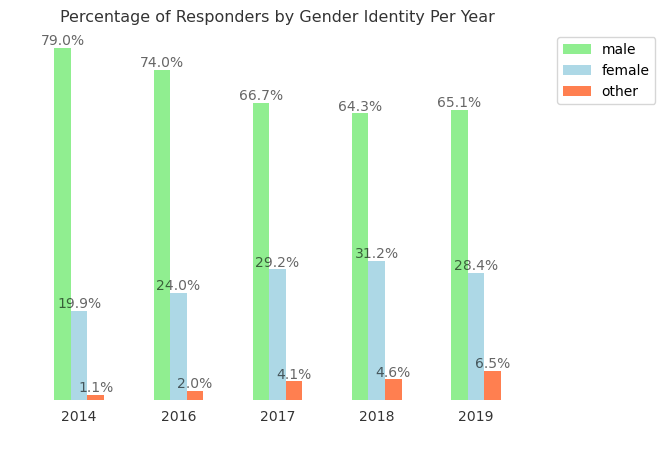

In [6]:
query = """
WITH CategorizedUsers AS (
    SELECT DISTINCT
        SurveyID,
        UserID,
        CASE
            WHEN LOWER(AnswerText) LIKE '%female%' OR LOWER(AnswerText) LIKE '%afab%' OR LOWER(AnswerText) LIKE '%woman%' THEN 'female'
            WHEN LOWER(AnswerText) LIKE '%male%' OR LOWER(AnswerText) LIKE '%man%' OR LOWER(AnswerText) LIKE '%amab%' THEN 'male'
            ELSE 'other'
        END AS category
    FROM Answer
    WHERE QuestionID = 2
)

SELECT 
    SurveyID,
    COUNT(DISTINCT CASE WHEN category = 'female' THEN UserID END) AS female_count,
    COUNT(DISTINCT CASE WHEN category = 'male' THEN UserID END) AS male_count,
    COUNT(DISTINCT CASE WHEN category = 'other' THEN UserID END) AS other_count
FROM CategorizedUsers
GROUP BY SurveyID
ORDER BY SurveyID;
"""

mf_responders_per_survey = pd.read_sql(query, conn)

# Calculate the total number of responders per year
mf_responders_per_survey['total_count'] = mf_responders_per_survey[['female_count', 'male_count', 'other_count']].sum(axis=1)

# Calculate the percentages for each gender category
mf_responders_per_survey['female_percentage'] = mf_responders_per_survey['female_count'] / mf_responders_per_survey['total_count'] * 100
mf_responders_per_survey['male_percentage'] = mf_responders_per_survey['male_count'] / mf_responders_per_survey['total_count'] * 100
mf_responders_per_survey['other_percentage'] = mf_responders_per_survey['other_count'] / mf_responders_per_survey['total_count'] * 100

# Plot the percentage data
plt.figure(figsize=(12, 8))
barplot = mf_responders_per_survey.plot.bar(x='SurveyID', y=['male_percentage', 'female_percentage', 'other_percentage'], color=['lightgreen', 'lightblue', 'coral'])

plt.title('Percentage of Responders by Gender Identity Per Year', fontsize=11.5, alpha=0.8)
plt.ylabel(' ')
plt.xlabel(' ')
plt.xticks(rotation=0, ha='center', alpha=0.8)
sns.despine(left=True, bottom=True, right=True, top=True) # Remove spines

plt.gca().tick_params(axis='y', which='both', left=False, labelleft=False)
plt.gca().tick_params(axis='x', which='both', left=False, bottom=False)

# Annotate each bar segment with the percentage
for p in barplot.patches:
    if p.get_height() != 0:  # Skip annotating zero values
        barplot.annotate(f'{p.get_height():.1f}%', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         fontsize=10, alpha=0.6,  # Adjust font size as needed
                         xytext=(0, 5), 
                         textcoords='offset points')

plt.legend(labels=['male', 'female', 'other'], loc='upper left', bbox_to_anchor=(1.05, 1)) # Adjust the second value in bbox_to_anchor to move legend
plt.show()

Responders filled in their own response to "What is your gender?" rather than picking from a set of possible responses. This data therefore tracks gender identity, not sex, though for many or most those are the same. I chose to group responses by male, female, and other. "Other" had a range of responses, some of them seeming sarcastic such as "I am a Wookie." Responders who wrote "trans man" or similar were grouped as male, and responders who wrote "trans woman" or similar were grouped as female. Responders who wrote "ftm" or "mtf" were grouped as "other," because to me the choice of language indicates they do not fully identiy with "female" or "male." This strategy made my data anlysis a bit easier. There can be many other strategies for analyzing and grouping this data. 

Every year, this survey is skewed male in varying degrees. It's unclear how this skew reflects the makeup of the employee demographics -- as in, is this reflective of how many men and women actually are in the field, or were men more likely to fill out the survey? According to Skillsoft's Women in Tech Report 2024, in 2024 women make up about 25% of the tech industry. The stats in our mental health survey appear to hover around that number, indicating that this survey seemingly reached men and women equitably for the most part. 

### Age

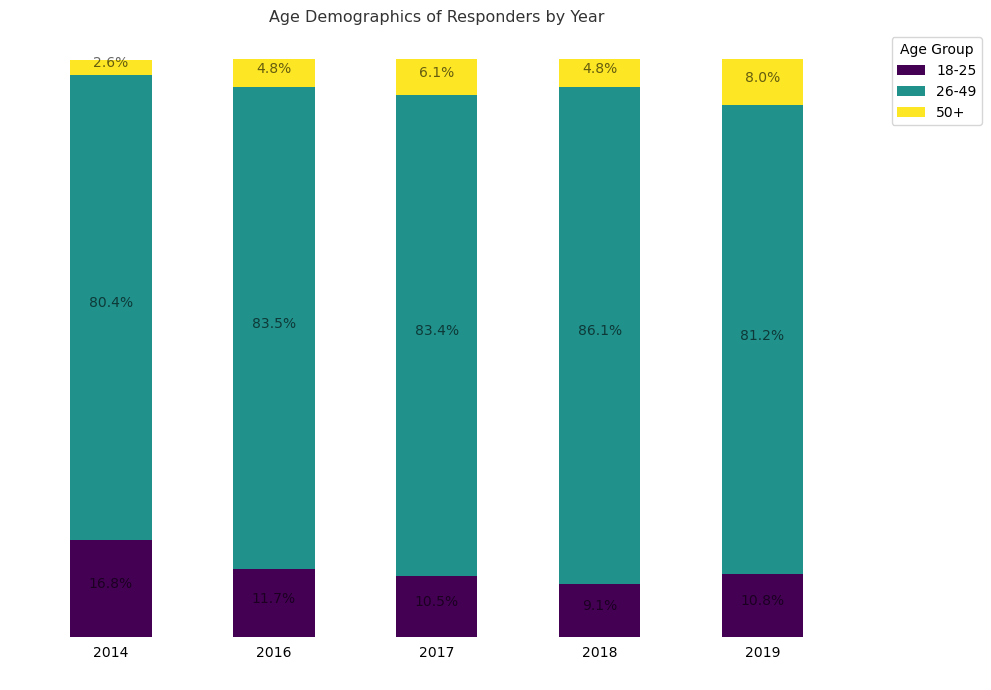

In [7]:
query = """
WITH AgeGroups AS (
    SELECT SurveyID,
           UserID,
           CASE
                WHEN AnswerText BETWEEN 18 AND 25 THEN '18-25'
                WHEN AnswerText BETWEEN 26 AND 49 THEN '26-49'
                WHEN AnswerText BETWEEN 50 AND 99 THEN '50+'
           END AS age_group
    FROM Answer
    WHERE SurveyID IN (2014, 2016, 2017, 2018, 2019)
          AND QuestionID = 1
          AND AnswerText > 18
),
AgeGroupCounts AS (
    SELECT SurveyID,
           age_group,
           COUNT(*) AS count
    FROM AgeGroups
    GROUP BY SurveyID, age_group
),
TotalCounts AS (
    SELECT SurveyID,
           COUNT(*) AS total_count
    FROM AgeGroups
    GROUP BY SurveyID
),
Percentage AS (
    SELECT a.SurveyID,
           a.age_group,
           (a.count * 100.0 / t.total_count) AS percentage
    FROM AgeGroupCounts a
    JOIN TotalCounts t ON a.SurveyID = t.SurveyID
)
SELECT SurveyID,
       age_group,
       percentage
FROM Percentage
ORDER BY SurveyID, age_group;
"""

df = pd.read_sql(query, conn)
df = df.dropna(subset=['age_group', 'percentage'])

# Pivot the DataFrame to get the percentage for each year and age group
pivot_df = df.pivot(index='SurveyID', columns='age_group', values='percentage').fillna(0)

# Create the stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='viridis')

for c in ax.containers:
    # Get the data of each chunk
    labels = [f'{v:.1f}%' if v > 0 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', padding=3, alpha=0.6)

sns.despine(left=True, bottom=True, right=True, top=True) # Remove spines

plt.gca().tick_params(axis='y', which='both', left=False, labelleft=False)
plt.gca().tick_params(axis='x', which='both', left=False, bottom=False)

# Adding labels and title
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Age Demographics of Responders by Year', fontsize=11.5, alpha=0.8)
plt.xticks(rotation=0)  # Rotate x-axis labels to make them more readable
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the plot

# Display the chart
plt.tight_layout()
plt.show()

In each year, the 26-49 age group filled out the survey at the highest rates, from 80.4% to 86.1%. I chose these age groups to match the age groups chosen by the National Institute of Mental Health (NIMH) in their demographic studies on mental illness. 

### Race

<Figure size 1200x600 with 0 Axes>

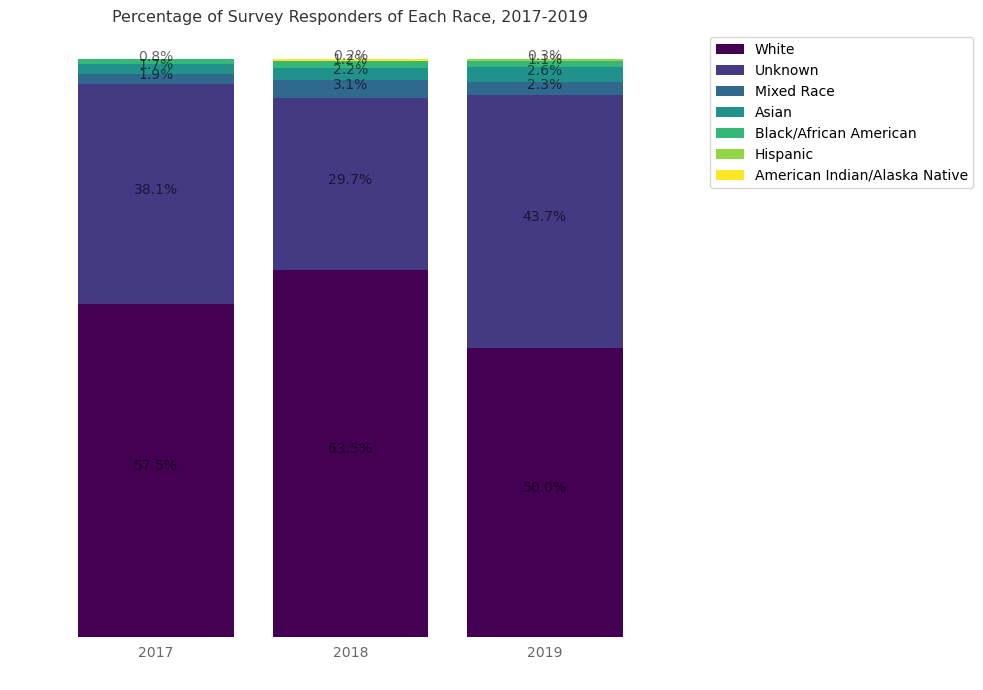

In [8]:
query = """
SELECT 
    SurveyID,
    CASE 
        WHEN AnswerText IN ('White', 'European American', 'Caucasian', 'White Hispanic') THEN 'White'
        WHEN AnswerText = 'More than one of the above' THEN 'Mixed Race'
        WHEN AnswerText = 'Asian' THEN 'Asian'
        WHEN AnswerText = 'Black or African American' THEN 'Black/African American'
        WHEN AnswerText IN ('-1', 'I prefer not to answer') THEN 'Unknown'
        WHEN AnswerText = 'American Indian or Alaska Native' THEN 'American Indian/Alaska Native'
        WHEN AnswerText = 'Hispanic' THEN 'Hispanic'
        ELSE 'Unknown'
    END AS race,
    COUNT(*) AS count
FROM Answer
WHERE QuestionID = 89
GROUP BY SurveyID, race
ORDER BY SurveyID, race;
"""

# Read the data into a DataFrame
df = pd.read_sql(query, conn)

# Pivot the DataFrame to get the count for each year and race
df_pivot = df.pivot(index='SurveyID', columns='race', values='count').fillna(0)

# Calculate the total number of responders for each year
total_responders = df_pivot.sum(axis=1)

# Calculate the percentages for each race category
df_percentage = df_pivot.divide(total_responders, axis=0) * 100

# Sort the columns by the total counts across all years
sorted_columns = df_percentage.sum().sort_values(ascending=False).index
df_percentage_sorted = df_percentage[sorted_columns]

# Plot the data
plt.figure(figsize=(12, 6))

# Create the stacked bar chart
ax = df_percentage_sorted.plot(kind='bar', stacked=True, colormap='viridis', width=0.8, figsize=(10, 7))

# Annotate the bars with their heights
for container in ax.containers:
    labels = [f'{v:.1f}%' if v > 0 else '' for v in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center', padding=3, alpha=0.6)

# Customize the plot
plt.title('Percentage of Survey Responders of Each Race, 2017-2019', fontsize=11.5, alpha=0.8)
plt.ylabel(' ')
plt.xlabel(' ')

# Adjust x-ticks to show only unique years
plt.xticks(ticks=range(len(df_percentage_sorted.index)), labels=df_percentage_sorted.index, rotation=0, ha='center', alpha=0.6)

# Customize the axes and remove spines
sns.despine(left=True, bottom=True, right=True, top=True)
plt.gca().tick_params(axis='y', which='both', left=False, labelleft=False)
plt.gca().tick_params(axis='x', which='both', left=False, bottom=False)

# Move the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

Does this data reflect the racial demographics of the tech industry? According to Zippia, "White workers make up a whopping 62% of the high-tech industry, Asian employees make up 20%, Hispanic and Latino workers account for 8%, and Black employees make up 7%." Ultimately, our mental health survey data is a bit hard to analyze on race due to the large proportion of people who declined to answer the question. It does appear that Asian, Black, and Hispanic employees are underrepresented in this survey. Particularly Asian people seem absent in the data. I wonder if Asian people were more likely to decline to respond on the race question. Though all of these racial categories are broad generalizations, perhaps "Asian" is not something many "Asians" self-identify as. Speaking for myself, being mixed race white/South Asian, I sometimes indicate myself as "Asian" in surveys and sometimes "other" or "prefer not to say."

I found it difficult to investigate how common it is to have large chunks of people who do not respond to questions about their racial identity. The United States Census Bureau has a lot more options for people to describe their race and ethnicity more specifically, but I could not find a category for those who don't report. The race information in the dataset we are working with raised some questions for me. Is it common to not report your race on a survey, or are people in tech more likely to not report it?

In any case, it seems clear that racial makeup of the tech industry was not represented accurately in this survey.

## At What Rates are Different Age Groups Reporting Mental Illness?

Questions about explicit mental health diagnoses were only present for survey year 2016. I used a keyword analysis to try to glean diagnosis information from other survey years 2017-2019. Since this keywod analysis is no doubt less accurate than the explicit answers in 2016, I include it because it's interesting, but do not make statistical comparisions to the NIMH data. 

The National Institute of Mental Health reports 22.3% of all adults in the United States report some kind of mental illness. Rates vary by age group. I'm not sure the logic NIMH uses to their 3 age categories, since it's not an equal split of years. Perhaps they have reasons for the large differences in interval size in their 3 categories, like what general life stage people tend to be in at those ages.

### Rates of Any Mental Illness (AMI) by Age Group: Percentages, 2016-2019

In [9]:
query_age_2017= """
WITH MentalHealth AS (
    SELECT SurveyID, 
           UserID,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%anxiety%' OR LOWER(AnswerText) LIKE '%panic%' OR LOWER(AnswerText) LIKE '%gad%' THEN 1 ELSE 0 END) AS Anxiety,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%depression%' OR LOWER(AnswerText) LIKE '%depressive%' OR LOWER(AnswerText) LIKE '%mdd%' THEN 1 ELSE 0 END) AS Depression,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%trauma%' OR LOWER(AnswerText) LIKE '%ptsd%' THEN 1 ELSE 0 END) AS PTSD,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%add%' OR LOWER(AnswerText) LIKE '%adhd%' THEN 1 ELSE 0 END) AS ADHD,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%bipolar%' OR LOWER(AnswerText) LIKE '%bp%' OR LOWER(AnswerText) LIKE '%mania%' THEN 1 ELSE 0 END) AS Bipolar,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%suicide%' THEN 1 ELSE 0 END) AS Suicidiality,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%pain%' OR LOWER(AnswerText) LIKE '%sleep%' THEN 1 ELSE 0 END) AS Somatic,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%ocd%' THEN 1 ELSE 0 END) AS OCD,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%autism%' OR LOWER(AnswerText) LIKE '%asperger%' THEN 1 ELSE 0 END) AS Autism,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%psychosis%' OR LOWER(AnswerText) LIKE '%psychotic%' OR LOWER(AnswerText) LIKE '%paranoia%' THEN 1 ELSE 0 END) AS Psychotic_Disorder,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%stress%' OR LOWER(AnswerText) LIKE '%burnout%' OR LOWER(AnswerText) LIKE '%burn%' OR LOWER(AnswerText) LIKE '%overwhelm%' THEN 1 ELSE 0 END) AS Burnout,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%death%' OR LOWER(AnswerText) LIKE '%bereavement%' OR LOWER(AnswerText) LIKE '%news%' OR LOWER(AnswerText) LIKE '%took his life%' OR LOWER(AnswerText) LIKE '%grief%' OR LOWER(AnswerText) LIKE '%tragedy%' OR LOWER(AnswerText) LIKE '%traumatic event%' OR LOWER(AnswerText) LIKE '%breakup%' OR LOWER(AnswerText) LIKE '%break up%' THEN 1 ELSE 0 END) AS Crisis,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%addiction%' OR LOWER(AnswerText) LIKE '%substance%' OR LOWER(AnswerText) LIKE '%alcoholism%' THEN 1 ELSE 0 END) AS Addictive_Disorder,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%hospital%' THEN 1 ELSE 0 END) AS Hospitalization,
           CASE 
               WHEN MAX(CASE WHEN LOWER(AnswerText) LIKE '%anxiety%' OR LOWER(AnswerText) LIKE '%panic%' OR LOWER(AnswerText) LIKE '%gad%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%depression%' OR LOWER(AnswerText) LIKE '%depressive%' OR LOWER(AnswerText) LIKE '%mdd%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%trauma%' OR LOWER(AnswerText) LIKE '%ptsd%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%add%' OR LOWER(AnswerText) LIKE '%adhd%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%bipolar%' OR LOWER(AnswerText) LIKE '%bp%' OR LOWER(AnswerText) LIKE '%mania%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%suicide%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%pain%' OR LOWER(AnswerText) LIKE '%sleep%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%ocd%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%autism%' OR LOWER(AnswerText) LIKE '%asperger%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%psychosis%' OR LOWER(AnswerText) LIKE '%psychotic%' OR LOWER(AnswerText) LIKE '%paranoia%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%stress%' OR LOWER(AnswerText) LIKE '%burnout%' OR LOWER(AnswerText) LIKE '%burn%' OR LOWER(AnswerText) LIKE '%overwhelm%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%death%' OR LOWER(AnswerText) LIKE '%bereavement%' OR LOWER(AnswerText) LIKE '%news%' OR LOWER(AnswerText) LIKE '%took his life%' OR LOWER(AnswerText) LIKE '%grief%' OR LOWER(AnswerText) LIKE '%tragedy%' OR LOWER(AnswerText) LIKE '%traumatic event%' OR LOWER(AnswerText) LIKE '%breakup%' OR LOWER(AnswerText) LIKE '%break up%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%addiction%' OR LOWER(AnswerText) LIKE '%substance%' OR LOWER(AnswerText) LIKE '%alcoholism%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%hospital%' THEN 1 ELSE 0 END) = 1
               THEN 1
               ELSE 0
           END AS MentalIllness
    FROM Answer
    WHERE QuestionID IN (46, 59, 61, 71, 73)
    GROUP BY SurveyID, UserID
),
AgeGroupCounts AS (
    SELECT SurveyID,
           UserID,
           CASE
                WHEN AnswerText BETWEEN 18 AND 25 THEN '18-25'
                WHEN AnswerText BETWEEN 26 AND 49 THEN '26-49'
                WHEN AnswerText BETWEEN 50 AND 99 THEN '50+'
           END AS age_group
    FROM Answer
    WHERE SurveyID IN (2014, 2016, 2017, 2018, 2019)
          AND QuestionID = 1
          AND AnswerText > 18
),
TotalResponders AS (
    SELECT SurveyID,
           COUNT(*) AS total_count
    FROM Answer
    WHERE SurveyID IN (2014, 2016, 2017, 2018, 2019)
          AND QuestionID = 1
          AND AnswerText > 18
    GROUP BY SurveyID
),
AgeGroupTotals AS (
    SELECT SurveyID,
           age_group,
           COUNT(*) AS age_group_total
    FROM AgeGroupCounts
    GROUP BY SurveyID, age_group
),
Aggregated AS (
    SELECT ag.SurveyID,
           ag.age_group,
           COUNT(*) AS age_group_count,
           SUM(mh.MentalIllness) AS mental_illness_count
    FROM AgeGroupCounts ag
    JOIN MentalHealth mh ON ag.SurveyID = mh.SurveyID AND ag.UserID = mh.UserID
    GROUP BY ag.SurveyID, ag.age_group
)
SELECT a.SurveyID,
       a.age_group,
       a.age_group_count,
       a.mental_illness_count,
       (a.mental_illness_count * 100.0 / agt.age_group_total) AS percentage_reporting_mental_illness,
       t.total_count
FROM Aggregated a
JOIN AgeGroupTotals agt ON a.SurveyID = agt.SurveyID AND a.age_group = agt.age_group
JOIN TotalResponders t ON a.SurveyID = t.SurveyID
ORDER BY a.SurveyID, a.age_group;
"""
df_age_2017 = pd.read_sql(query_age_2017, conn)

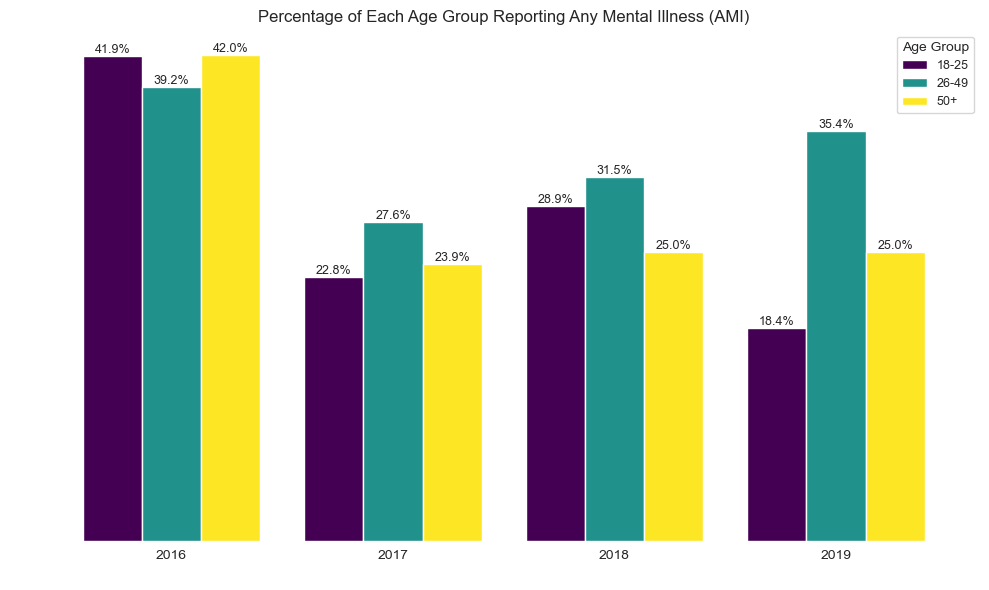

In [11]:
query = """
    WITH AgeGroup2016 AS (
    SELECT SurveyID,
           UserID,
           CASE
                WHEN AnswerText BETWEEN 18 AND 25 THEN '18-25'
                WHEN AnswerText BETWEEN 26 AND 49 THEN '26-49'
                WHEN AnswerText >= 50 THEN '50+'
           END AS age_group
    FROM Answer
    WHERE SurveyID = 2016
          AND QuestionID = 1
          AND AnswerText >= 18
),
TotalResponders AS (
    SELECT SurveyID,
           COUNT(DISTINCT UserID) AS total_count
    FROM Answer
    WHERE SurveyID = 2016
),
MentalHealth2016 AS (
    SELECT SurveyID,
           UserID,
           CASE WHEN QuestionID='115' AND AnswerText !='-1' THEN 1 ELSE 0 END AS MentalIllness
    FROM Answer
    WHERE SurveyID = 2016
),
AgeGroupTotals AS (
    SELECT SurveyID,
           age_group,
           COUNT(DISTINCT UserID) AS age_group_count
    FROM AgeGroup2016
    GROUP BY SurveyID, age_group
),
MentalIllnessTotals AS (
    SELECT ag.SurveyID,
           ag.age_group,
           COUNT(DISTINCT mh.UserID) AS mental_illness_count
    FROM AgeGroup2016 ag
    JOIN MentalHealth2016 mh ON ag.SurveyID = mh.SurveyID AND ag.UserID = mh.UserID
    WHERE mh.MentalIllness = 1
    GROUP BY ag.SurveyID, ag.age_group
)
SELECT a.SurveyID,
       a.age_group,
       a.age_group_count,
       COALESCE(m.mental_illness_count, 0) AS mental_illness_count,
       (COALESCE(m.mental_illness_count, 0) * 100.0 / a.age_group_count) AS percentage_reporting_mental_illness,
       t.total_count
FROM AgeGroupTotals a
LEFT JOIN MentalIllnessTotals m ON a.SurveyID = m.SurveyID AND a.age_group = m.age_group
JOIN TotalResponders t ON a.SurveyID = t.SurveyID
ORDER BY a.SurveyID, a.age_group;
"""

sns.set_style(style='white')

df_age_2016 = pd.read_sql(query, conn)

# Combine the 2016 data with 2017–2019
df_combined = pd.concat([df_age_2016, df_age_2017], ignore_index=True)

# Pivot the DataFrame to get age groups as columns
pivot_df_combined = df_combined.pivot(index='SurveyID', columns='age_group', values='percentage_reporting_mental_illness')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

pivot_df_combined.plot(kind='bar', ax=ax, width=0.8, colormap='viridis')

ax.set_yticks([])

ax.set_title('Percentage of Each Age Group Reporting Any Mental Illness (AMI)', fontsize=12)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.legend(title='Age Group', fontsize=9)
ax.grid(False)

# Add annotations
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if not pd.isna(height):
            ax.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        fontsize=9,
                        ha='center',
                        va='bottom')

sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In 2016, 41.9% of 18-25 year olds in the tech survey reported any mental illness (AMI), compared to the NIMH statistic of 33.7%. 26-49 year olds in the 2016 survey reported AMI at a rate of 39.2%, compared to the NIMH statistic of 28.1%. Finally, 42% of the age 50+ responders in 2016 reported AMI, compared to 15% reported by NIMH.

Across all age groups, reported diagnosis of AMI is higher than NIMH's reported rates. Are these differences statistically significant?

### Rates of Any Mental Illness (AMI) by Age Group: Statistical Significance, 2016 Survey Rates vs. NIMH Rates

Hypotheses:
+ Null Hypothesis: The 2016 survey rates of AMI are not statistically significantly different than the NIMH reported rates.
+ Alternative Hypothesis: The 2016 survey rates of AMI are statistically significantly different than the NIMH reported rates.

In [12]:
def calculate_ami_rate(survey_ami_count, total_respondents):
    return (survey_ami_count / total_respondents) * 100

# Number of bootstrap samples
n_bootstrap_samples = 10000

# NIMH AMI rates
nimh_ami_18 = 33.7
nimh_ami_26 = 28.1
nimh_ami_50 = 15.0
nimh_ami_all = 23.1

# Survey data
survey_ami_18_count = 70
survey_ami_26_count = 469
survey_ami_50_count = 29
survey_ami_all_count = 568

survey_ami_18_total = 167
survey_ami_26_total = 1193
survey_ami_50_total = 70
survey_ami_all_total = 1433

# Bootstrap resampling function
def bootstrap_ami_rate(survey_ami_count, survey_total, n_samples):
    bootstrap_rates = []
    for _ in range(n_samples):
        # Resample with replacement
        resample_ami_count = np.random.binomial(survey_total, survey_ami_count / survey_total)
        bootstrap_rate = calculate_ami_rate(resample_ami_count, survey_total)
        bootstrap_rates.append(bootstrap_rate)
    return bootstrap_rates

# Get bootstrap rates for each age group
bootstrap_ami_18 = bootstrap_ami_rate(survey_ami_18_count, survey_ami_18_total, n_bootstrap_samples)
bootstrap_ami_26 = bootstrap_ami_rate(survey_ami_26_count, survey_ami_26_total, n_bootstrap_samples)
bootstrap_ami_50 = bootstrap_ami_rate(survey_ami_50_count, survey_ami_50_total, n_bootstrap_samples)
bootstrap_ami_all = bootstrap_ami_rate(survey_ami_all_count, survey_ami_all_total, n_bootstrap_samples)

def calculate_p_value(bootstrap_distribution, nimh_rate):
    # Calculate how many bootstrap samples are less than or greater than the NIMH rate
    above_nimh = np.sum(np.array(bootstrap_distribution) >= nimh_rate)
    below_nimh = np.sum(np.array(bootstrap_distribution) <= nimh_rate)
    p_value = min(above_nimh, below_nimh) / len(bootstrap_distribution)
    return p_value

# Calculate p-values for each age group
p_value_18 = calculate_p_value(bootstrap_ami_18, nimh_ami_18)
p_value_26 = calculate_p_value(bootstrap_ami_26, nimh_ami_26)
p_value_50 = calculate_p_value(bootstrap_ami_50, nimh_ami_50)
p_value_all = calculate_p_value(bootstrap_ami_all, nimh_ami_all)

# Output the results
print(f"18-25 Age Group: p-value = {p_value_18:.4f}")
print(f"26-49 Age Group: p-value = {p_value_26:.4f}")
print(f"50+ Age Group: p-value = {p_value_50:.4f}")
print(f"All Age Groups: p-value = {p_value_all:.4f}")

18-25 Age Group: p-value = 0.0147
26-49 Age Group: p-value = 0.0000
50+ Age Group: p-value = 0.0000
All Age Groups: p-value = 0.0000


In all cases, the p-value is less than the alpha significance level of 0.05. This means the Null Hypotheis, that the difference is not statistically significant, is rejected.

A visual can illustrate this more intuitively.

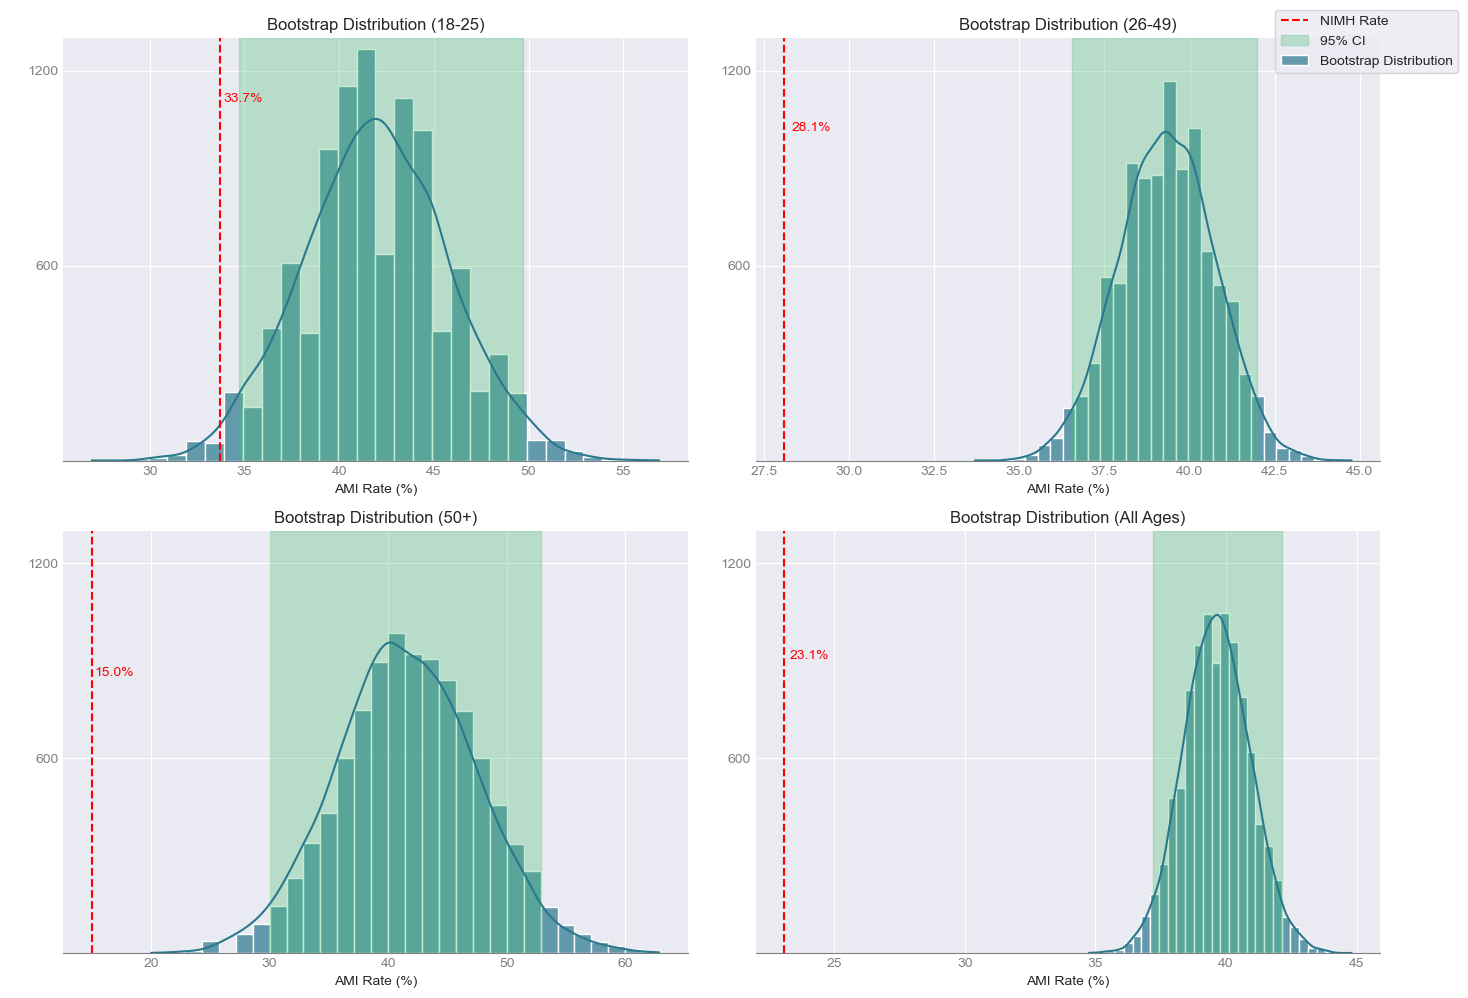

In [13]:
sns.set_style(style='darkgrid')

# Function to plot bootstrap distribution, NIMH rate, and confidence intervals with shaded area
def plot_bootstrap_distribution(bootstrap_distribution, nimh_rate, age_group, ax, colormap):
    # Calculate confidence intervals
    ci_lower = np.percentile(bootstrap_distribution, 2.5)
    ci_upper = np.percentile(bootstrap_distribution, 97.5)
    
    # Plot the histogram of the bootstrap distribution
    sns.histplot(bootstrap_distribution, bins=30, kde=True, ax=ax, color=colormap(0.4), alpha=0.7, label=f'Bootstrap distribution {age_group}', edgecolor=None)
    
    # Plot NIMH rate
    ax.axvline(nimh_rate, color='r', linestyle='--', label=f'NIMH Rate {age_group}')

    # Add text label for NIMH rate
    ax.text(
        nimh_rate + 0.2,  # Adjust horizontal position to avoid overlap
        ax.get_ylim()[1] * 0.85,  # Adjust vertical position
        f'{nimh_rate}%',  # Label with the NIMH rate value
        color='r', fontsize=10, verticalalignment='top'
    )

    # Shade the area between the confidence intervals
    ax.fill_betweenx(
        y=[0, 1300],  # Extend the shading to the full y-axis limit
        x1=ci_lower, x2=ci_upper,
        color=colormap(0.7), alpha=0.3, label=f'95% CI {age_group}'
    )
    
    # Title and labels
    ax.set_title(f'Bootstrap Distribution ({age_group})')
    ax.set_xlabel('AMI Rate (%)')
    ax.set_ylabel(' ')

    # Set y-axis limit to 1300
    ax.set_ylim(0, 1300)

    # Set y-axis ticks to only 0, 600, 1200
    ax.set_yticks([600, 1200])

    ax.spines['bottom'].set_color('gray')
    
    # Set label color to gray
    ax.tick_params(axis='y', length=0, labelcolor='gray')
    ax.tick_params(axis='x', length=0, labelcolor='gray')

    
# Create subplots for each age group and the overall age group
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid for subplots

sns.despine(left=True)

# Use viridis colormap
colormap = plt.cm.viridis

# Plot for 18-25 age group
plot_bootstrap_distribution(bootstrap_ami_18, nimh_ami_18, '18-25', axes[0, 0], colormap)

# Plot for 26-49 age group
plot_bootstrap_distribution(bootstrap_ami_26, nimh_ami_26, '26-49', axes[0, 1], colormap)

# Plot for 50+ age group
plot_bootstrap_distribution(bootstrap_ami_50, nimh_ami_50, '50+', axes[1, 0], colormap)

# Plot for All age groups
plot_bootstrap_distribution(bootstrap_ami_all, nimh_ami_all, 'All Ages', axes[1, 1], colormap)

# Adjust the layout for better spacing
plt.tight_layout()

# Create one legend for all subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
# Shorten the labels for the legend
short_labels = ['NIMH Rate', '95% CI', 'Bootstrap Distribution']
fig.legend(handles, short_labels, loc='upper right', bbox_to_anchor=(1.05, 1), title="")

# Display the plot
plt.show()

In all age groups, responders in 2016 reported higher rates of AMI than in the NIMH survey. The closest the NIMH rate comes is in the 18-26 age group, nodded to by the p-value of 0.0147, larger than all the other p-values of 0. 

The final subplot shows that across all age groups (as well as within them, indicated by the other subplots) the 2016 reported higher rates of AMI. 

## At What Rates are Different Genders Reporting Mental Illness?

### Rates of Any Mental Illness (AMI) by Gender: Percentages, 2016-2019

In [22]:
query_gender_2016 = """
WITH MentalHealth2016 AS (
    SELECT 
        SurveyID,
        UserID,
        CASE WHEN QuestionID = '115' AND AnswerText != '-1' THEN 1 ELSE 0 END AS MentalIllness
    FROM Answer
    WHERE SurveyID = 2016
),
CategorizedUsers AS (
    SELECT DISTINCT
        SurveyID,
        UserID,
        CASE
            WHEN LOWER(AnswerText) LIKE '%female%' OR LOWER(AnswerText) LIKE '%afab%' OR LOWER(AnswerText) LIKE '%woman%' THEN 'female'
            WHEN LOWER(AnswerText) LIKE '%male%' OR LOWER(AnswerText) LIKE '%amab%' OR LOWER(AnswerText) LIKE '%man%' THEN 'male'
            ELSE 'other'
        END AS category
    FROM Answer
    WHERE QuestionID = 2
),
GenderMentalHealth AS (
    SELECT 
        mh.SurveyID,
        COUNT(DISTINCT CASE WHEN cu.category = 'female' THEN cu.UserID END) AS female_count,
        COUNT(DISTINCT CASE WHEN cu.category = 'male' THEN cu.UserID END) AS male_count,
        COUNT(DISTINCT CASE WHEN cu.category = 'other' THEN cu.UserID END) AS other_count
    FROM MentalHealth2016 mh
    JOIN CategorizedUsers cu ON mh.UserID = cu.UserID AND mh.SurveyID = cu.SurveyID
    WHERE mh.MentalIllness = 1
    GROUP BY mh.SurveyID
),
TotalGenderResponders AS (
    SELECT 
        SurveyID,
        COUNT(DISTINCT CASE WHEN category = 'female' THEN UserID END) AS total_female_responders,
        COUNT(DISTINCT CASE WHEN category = 'male' THEN UserID END) AS total_male_responders,
        COUNT(DISTINCT CASE WHEN category = 'other' THEN UserID END) AS total_other_responders
    FROM CategorizedUsers
    GROUP BY SurveyID
)
SELECT 
    gm.SurveyID,
    100.0 * gm.female_count / tgr.total_female_responders AS female_percentage,
    100.0 * gm.male_count / tgr.total_male_responders AS male_percentage,
    100.0 * gm.other_count / tgr.total_other_responders AS other_percentage
FROM GenderMentalHealth gm
JOIN TotalGenderResponders tgr ON gm.SurveyID = tgr.SurveyID
ORDER BY gm.SurveyID;
"""
df_gender_2016 = pd.read_sql(query_gender_2016, conn)

In [23]:
query_gender_2017 = """
WITH MentalHealth AS (
    SELECT SurveyID, 
           UserID,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%anxiety%' OR LOWER(AnswerText) LIKE '%panic%' OR LOWER(AnswerText) LIKE '%gad%' THEN 1 ELSE 0 END) AS Anxiety,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%depression%' OR LOWER(AnswerText) LIKE '%depressive%' OR LOWER(AnswerText) LIKE '%mdd%' THEN 1 ELSE 0 END) AS Depression,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%trauma%' OR LOWER(AnswerText) LIKE '%ptsd%' THEN 1 ELSE 0 END) AS PTSD,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%add%' OR LOWER(AnswerText) LIKE '%adhd%' THEN 1 ELSE 0 END) AS ADHD,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%bipolar%' OR LOWER(AnswerText) LIKE '%bp%' OR LOWER(AnswerText) LIKE '%mania%' THEN 1 ELSE 0 END) AS Bipolar,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%suicide%' THEN 1 ELSE 0 END) AS Suicidiality,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%pain%' OR LOWER(AnswerText) LIKE '%sleep%' THEN 1 ELSE 0 END) AS Somatic,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%ocd%' THEN 1 ELSE 0 END) AS OCD,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%autism%' OR LOWER(AnswerText) LIKE '%asperger%' THEN 1 ELSE 0 END) AS Autism,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%psychosis%' OR LOWER(AnswerText) LIKE '%psychotic%' OR LOWER(AnswerText) LIKE '%paranoia%' THEN 1 ELSE 0 END) AS Psychotic_Disorder,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%stress%' OR LOWER(AnswerText) LIKE '%burnout%' OR LOWER(AnswerText) LIKE '%burn%' OR LOWER(AnswerText) LIKE '%overwhelm%' THEN 1 ELSE 0 END) AS Burnout,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%death%' OR LOWER(AnswerText) LIKE '%bereavement%' OR LOWER(AnswerText) LIKE '%news%' OR LOWER(AnswerText) LIKE '%took his life%' OR LOWER(AnswerText) LIKE '%grief%' OR LOWER(AnswerText) LIKE '%tragedy%' OR LOWER(AnswerText) LIKE '%traumatic event%' OR LOWER(AnswerText) LIKE '%breakup%' OR LOWER(AnswerText) LIKE '%break up%' THEN 1 ELSE 0 END) AS Crisis,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%addiction%' OR LOWER(AnswerText) LIKE '%substance%' OR LOWER(AnswerText) LIKE '%alcoholism%' THEN 1 ELSE 0 END) AS Addictive_Disorder,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%hospital%' THEN 1 ELSE 0 END) AS Hospitalization,
           CASE 
               WHEN MAX(CASE WHEN LOWER(AnswerText) LIKE '%anxiety%' OR LOWER(AnswerText) LIKE '%panic%' OR LOWER(AnswerText) LIKE '%gad%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%depression%' OR LOWER(AnswerText) LIKE '%depressive%' OR LOWER(AnswerText) LIKE '%mdd%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%trauma%' OR LOWER(AnswerText) LIKE '%ptsd%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%add%' OR LOWER(AnswerText) LIKE '%adhd%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%bipolar%' OR LOWER(AnswerText) LIKE '%bp%' OR LOWER(AnswerText) LIKE '%mania%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%suicide%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%pain%' OR LOWER(AnswerText) LIKE '%sleep%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%ocd%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%autism%' OR LOWER(AnswerText) LIKE '%asperger%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%psychosis%' OR LOWER(AnswerText) LIKE '%psychotic%' OR LOWER(AnswerText) LIKE '%paranoia%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%stress%' OR LOWER(AnswerText) LIKE '%burnout%' OR LOWER(AnswerText) LIKE '%burn%' OR LOWER(AnswerText) LIKE '%overwhelm%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%death%' OR LOWER(AnswerText) LIKE '%bereavement%' OR LOWER(AnswerText) LIKE '%news%' OR LOWER(AnswerText) LIKE '%took his life%' OR LOWER(AnswerText) LIKE '%grief%' OR LOWER(AnswerText) LIKE '%tragedy%' OR LOWER(AnswerText) LIKE '%traumatic event%' OR LOWER(AnswerText) LIKE '%breakup%' OR LOWER(AnswerText) LIKE '%break up%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%addiction%' OR LOWER(AnswerText) LIKE '%substance%' OR LOWER(AnswerText) LIKE '%alcoholism%' THEN 1 ELSE 0 END) = 1
               OR MAX(CASE WHEN LOWER(AnswerText) LIKE '%hospital%' THEN 1 ELSE 0 END) = 1
               THEN 1
               ELSE 0
           END AS MentalIllness
    FROM Answer
    WHERE QuestionID IN (46, 59, 61, 71, 73)
    GROUP BY SurveyID, UserID
),
CategorizedUsers AS (
    SELECT DISTINCT
        SurveyID,
        UserID,
        CASE
            WHEN LOWER(AnswerText) LIKE '%female%' OR LOWER(AnswerText) LIKE '%afab%' OR LOWER(AnswerText) LIKE '%woman%' THEN 'female'
            WHEN LOWER(AnswerText) LIKE '%male%' OR LOWER(AnswerText) LIKE '%man%' OR LOWER(AnswerText) LIKE '%amab%' THEN 'male'
            ELSE 'other'
        END AS category
    FROM Answer
    WHERE QuestionID = 2
),
GenderMentalHealth AS (
    SELECT 
        mh.SurveyID,
        COUNT(DISTINCT CASE WHEN cu.category = 'female' THEN cu.UserID END) AS female_count,
        COUNT(DISTINCT CASE WHEN cu.category = 'male' THEN cu.UserID END) AS male_count,
        COUNT(DISTINCT CASE WHEN cu.category = 'other' THEN cu.UserID END) AS other_count,
        COUNT(DISTINCT cu.UserID) AS total_users
    FROM MentalHealth mh
    JOIN CategorizedUsers cu ON mh.UserID = cu.UserID AND mh.SurveyID = cu.SurveyID
    WHERE mh.MentalIllness = 1
    GROUP BY mh.SurveyID
),
TotalResponders AS (
    SELECT 
        SurveyID,
        COUNT(DISTINCT UserID) AS total_responders
    FROM Answer
    WHERE QuestionID = 1
    GROUP BY SurveyID
)
SELECT 
    gm.SurveyID,
    100.0 * gm.female_count / t.total_responders AS female_percentage,
    100.0 * gm.male_count / t.total_responders AS male_percentage,
    100.0 * gm.other_count / t.total_responders AS other_percentage
FROM GenderMentalHealth gm
JOIN TotalResponders t ON gm.SurveyID = t.SurveyID
ORDER BY gm.SurveyID;
"""

df_gender_2017 = pd.read_sql(query_gender_2017, conn)

# Combine the 2016 data with 2017–2019
df_combined = pd.concat([df_gender_2016, df_gender_2017], ignore_index=True)

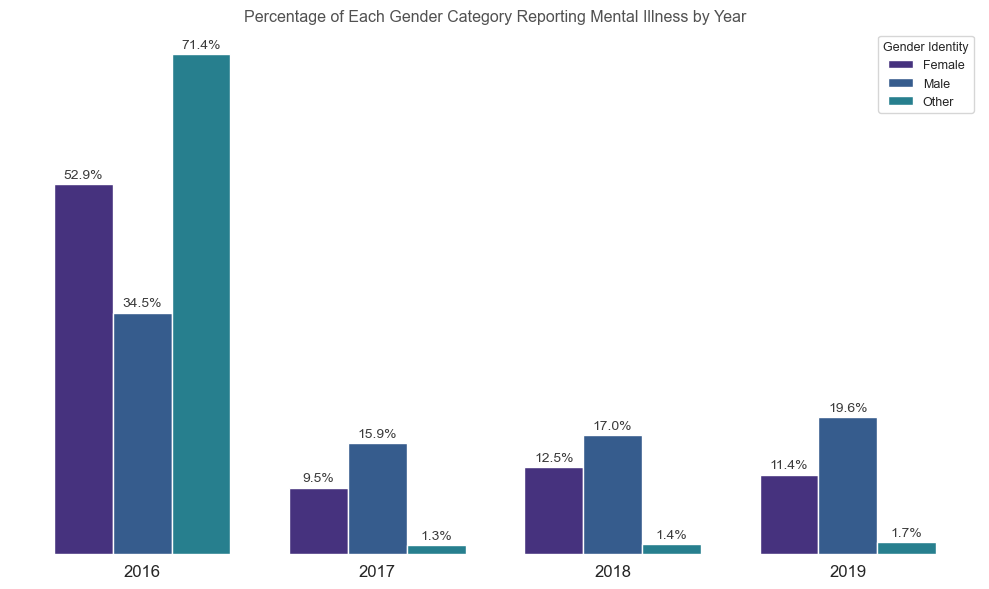

In [24]:
sns.set_style(style='white')

# Assuming `df` contains the data
fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis objects

# Bar settings
bar_width = 0.25
bar_positions = range(len(df_combined))
colors = sns.color_palette("viridis")[0:3]  # Use colors from the palette
alphas = [0.8, 0.6, 0.4]  # Define alpha levels for bars

# Plot each gender category
for i, (gender, alpha) in enumerate(zip(['female_percentage', 'male_percentage', 'other_percentage'], alphas)):
    ax.bar(
        [p + i * bar_width for p in bar_positions],
        df_combined[gender],
        width=bar_width,
        label=gender.replace('_percentage', '').capitalize(),
        color=colors[i],
        #alpha=alphas  # Apply alpha levels
    )

# Configure x-axis
ax.set_xticks([p + bar_width for p in bar_positions])
ax.set_xticklabels(df_combined['SurveyID'], fontsize=12)  # Adjust font size for better readability
ax.set_xlabel('')
ax.set_ylabel('')

# Set title
ax.set_title('Percentage of Each Gender Category Reporting Mental Illness by Year', fontsize=11.5, alpha=0.8)

# Add legend
ax.legend(title='Gender Identity', fontsize=9, title_fontsize=9)

# Remove chart spines for cleaner look
sns.despine(left=True, bottom=True, right=True, top=True)

# Adding value labels on top of the bars
for i, year in enumerate(df_combined['SurveyID']):
    for j, gender in enumerate(['female_percentage', 'male_percentage', 'other_percentage']):
        value = df_combined[gender].iloc[i]
        ax.text(
            x=i + j * bar_width,
            y=value + 0.5,
            s=f"{value:.1f}%",
            ha='center',
            va='bottom',
            fontsize=10,
            alpha=0.9  # Slight transparency for text labels
        )

plt.gca().tick_params(axis='y', which='both', left=False, labelleft=False)
plt.gca().tick_params(axis='x', which='both', left=False, bottom=False)

# Adjust layout for clean display
fig.tight_layout()

# Display the plot
plt.show()

NIMH's data shows females in the United States reporting any mental illness (AMI) at 27.2%, and males reporting at 18.1%. In the 2016 survey, 52.9%% of females reported AMI, and 34.5% of males. A shocking 71.4% of those in the "other" gender category reported mental illness. This could be due to gender dysphoria diagnoses, or something else. NIMH doesn't have data for those in other gender categories, so I cannot compare it.

Are these differences in male and female reported rates statistically signiciant?


### Rates of Any Mental Illness (AMI) by Gender: Statistical Significance, 2016 Survey Rates vs. NIMH Rates

Hypotheses:
+ Null Hypothesis: The 2016 survey rates of AMI are not statistically significantly different than the NIMH reported rates.
+ Alternative Hypothesis: The 2016 survey rates of AMI are statistically significantly different than the NIMH reported rates.

In [25]:
def calculate_ami_rate(survey_ami_count, total_respondents):
    return (survey_ami_count / total_respondents) * 100

# Number of bootstrap samples
n_bootstrap_samples = 10000

# NIMH AMI rates
nimh_ami_female = 27.2
nimh_ami_male = 18.1
nimh_ami_all = 23.1

# Survey data
survey_ami_female_count = 182
survey_ami_male_count = 366
survey_ami_all_count = 548

survey_ami_female_total = 344
survey_ami_male_total = 1061
survey_all_total = 1433

# Bootstrap resampling function
def bootstrap_ami_rate(survey_ami_count, survey_total, n_samples):
    bootstrap_rates = []
    for _ in range(n_samples):
        # Resample with replacement
        resample_ami_count = np.random.binomial(survey_total, survey_ami_count / survey_total)
        bootstrap_rate = calculate_ami_rate(resample_ami_count, survey_total)
        bootstrap_rates.append(bootstrap_rate)
    return bootstrap_rates

# Get bootstrap rates for each age group
bootstrap_ami_female = bootstrap_ami_rate(survey_ami_female_count, survey_ami_female_total, n_bootstrap_samples)
bootstrap_ami_male = bootstrap_ami_rate(survey_ami_male_count, survey_ami_male_total, n_bootstrap_samples)
bootstrap_ami_all = bootstrap_ami_rate(survey_ami_all_count, survey_all_total, n_bootstrap_samples)

def calculate_p_value(bootstrap_distribution, nimh_rate):
    # Calculate how many bootstrap samples are less than or greater than the NIMH rate
    above_nimh = np.sum(np.array(bootstrap_distribution) >= nimh_rate)
    below_nimh = np.sum(np.array(bootstrap_distribution) <= nimh_rate)
    p_value = min(above_nimh, below_nimh) / len(bootstrap_distribution)
    return p_value

# Calculate p-values for each age group
p_value_female = calculate_p_value(bootstrap_ami_female, nimh_ami_female)
p_value_male = calculate_p_value(bootstrap_ami_male, nimh_ami_female)
p_value_all = calculate_p_value(bootstrap_ami_all, nimh_ami_all)

# Output the results
print(f"Female: p-value = {p_value_female:.4f}")
print(f"Male: p-value = {p_value_male:.4f}")
print(f"All: p-value = {p_value_all:.4f}")

Female: p-value = 0.0000
Male: p-value = 0.0000
All: p-value = 0.0000


In all cases, the p-value is less than the alpha significance level of 0.05. This means the Null Hypotheis, that the difference is not statistically significant, is rejected.

A visual can illustrate this more intuitively.

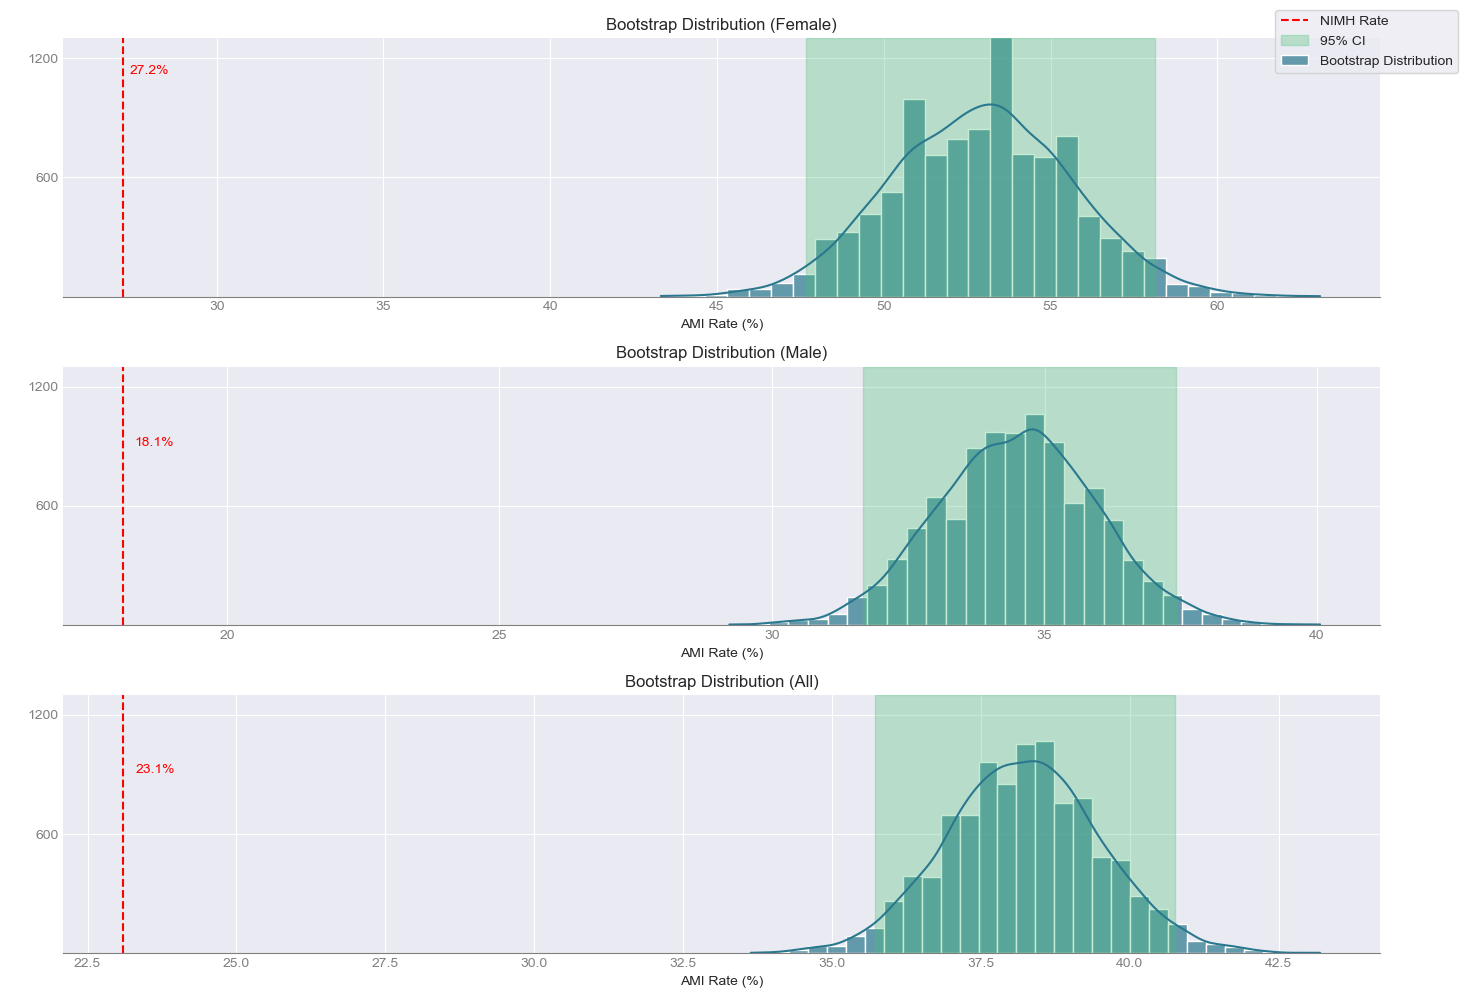

In [26]:
sns.set_style(style='darkgrid')

# Function to plot bootstrap distribution, NIMH rate, and confidence intervals with shaded area
def plot_bootstrap_distribution(bootstrap_distribution, nimh_rate, gender, ax, colormap):
    # Calculate confidence intervals
    ci_lower = np.percentile(bootstrap_distribution, 2.5)
    ci_upper = np.percentile(bootstrap_distribution, 97.5)
    
    # Plot the histogram of the bootstrap distribution
    sns.histplot(bootstrap_distribution, bins=30, kde=True, ax=ax, color=colormap(0.4), alpha=0.7, label=f'Bootstrap distribution {gender}', edgecolor=None)
    
    # Plot NIMH rate
    ax.axvline(nimh_rate, color='r', linestyle='--', label=f'NIMH Rate {gender}')

    # Add text label for NIMH rate
    ax.text(
        nimh_rate + 0.2,  # Adjust horizontal position to avoid overlap
        ax.get_ylim()[1] * 0.85,  # Adjust vertical position
        f'{nimh_rate}%',  # Label with the NIMH rate value
        color='r', fontsize=10, verticalalignment='top'
    )

    # Shade the area between the confidence intervals
    ax.fill_betweenx(
        y=[0, 1300],  # Extend the shading to the full y-axis limit
        x1=ci_lower, x2=ci_upper,
        color=colormap(0.7), alpha=0.3, label=f'95% CI {gender}'
    )
    
    # Title and labels
    ax.set_title(f'Bootstrap Distribution ({gender})')
    ax.set_xlabel('AMI Rate (%)')
    ax.set_ylabel(' ')

    # Set y-axis limit to 1300
    ax.set_ylim(0, 1300)

    # Set y-axis ticks to only 0, 600, 1200
    ax.set_yticks([600, 1200])

    ax.spines['bottom'].set_color('gray')
    
    # Set label color to gray
    ax.tick_params(axis='y', length=0, labelcolor='gray')
    ax.tick_params(axis='x', length=0, labelcolor='gray')

# Create subplots for each age group and the overall age group
fig, axes = plt.subplots(3, 1, figsize=(14, 10))  # 3x1 grid for subplots

# Use viridis colormap
colormap = plt.cm.viridis

# Plot for 18-25 age group
plot_bootstrap_distribution(bootstrap_ami_female, nimh_ami_female, 'Female', axes[0], colormap)

# Plot for 26-49 age group
plot_bootstrap_distribution(bootstrap_ami_male, nimh_ami_male, 'Male', axes[1], colormap)

# Plot for All age groups
plot_bootstrap_distribution(bootstrap_ami_all, nimh_ami_all, 'All', axes[2], colormap)

sns.despine(left=True)
plt.tight_layout()

# Create one legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
# Shorten the labels for the legend
short_labels = ['NIMH Rate', '95% CI', 'Bootstrap Distribution']
fig.legend(handles, short_labels, loc='upper right', bbox_to_anchor=(1.05, 1), title="")

# Display the plot
plt.show()


In both gender groups and (again) across all the data, the 2016 survey respondents reported higher rates of AMI at a statistically significant level.

NIMH's data appears to be based on sex, unlike the Kaggle dataset, which is self-reported gender identity. This may be one reason for the differences in statistics. In comparison to NIMH statistics, females in this survey are showing up lower than expected, and males higher. This could reflect different levels of comfortability filling out the survey question. It might reflect that people in the tech industry have higher rates of mental illness than the general population. Or, perhaps NIMH's data underestimates rates.


## Rates of Specific Mental Health Conditions

In [27]:
query_rates_2016= """
SELECT SurveyID, 
        SUM(Anxiety) AS Anxiety,
        SUM(Mood_Disorder) AS Mood_Disorder,
        SUM(PTSD) AS PTSD,
        SUM(ADHD) AS ADHD,
        SUM(OCD) AS OCD,
        SUM(Autism) AS Autism,
        SUM(Psychotic_Disorder) AS Psychotic_Disorder,
        SUM(Burnout) AS Burnout,
        SUM(Addictive_Disorder) AS Addictive_Disorder,
        SUM(Other) AS Other,
        SUM(Personality_Disorder) AS Personality_Disorder,
        SUM(Dissociative_Disorder) AS Dissociative_Disorder,
        SUM(Eating_Disorder) AS Eating_Disorder
FROM (
    SELECT SurveyID, 
           UserID,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%autism%' OR LOWER(AnswerText) LIKE '%asperger%' THEN 1 ELSE 0 END) AS Autism,
           MAX(CASE WHEN AnswerText = 'Anxiety Disorder (Generalized, Social, Phobia, etc)' THEN 1 ELSE 0 END) AS Anxiety,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%suicide%' THEN 1 ELSE 0 END) AS Suicidiality,
           MAX(CASE WHEN AnswerText IN ('Mood Disorder (Depression, Bipolar Disorder, etc)', 'Seasonal Affective Disorder', 'post-partum / anxiety', 'depression') THEN 1 ELSE 0 END) AS Mood_Disorder,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%personality%' THEN 1 ELSE 0 END) AS Personality_Disorder,
           MAX(CASE WHEN AnswerText = 'Obsessive-Compulsive Disorder' THEN 1 ELSE 0 END) AS OCD,
           MAX(CASE WHEN AnswerText = 'Eating Disorder (Anorexia, Bulimia, etc)' THEN 1 ELSE 0 END) AS Eating_Disorder,
           MAX(CASE WHEN AnswerText IN ('Attention Deficit Hyperactivity Disorder', 'ADD (w/o Hyperactivity)') THEN 1 ELSE 0 END) AS ADHD,
           MAX(CASE WHEN AnswerText IN ('Addictive Disorder', 'Sexual addiction', 'Substance Use Disorder') THEN 1 ELSE 0 END) AS Addictive_Disorder,
           MAX(CASE WHEN AnswerText IN ('Post-traumatic Stress Disorder', 'PTSD (undiagnosed)') THEN 1 ELSE 0 END) AS PTSD,
           MAX(CASE WHEN AnswerText IN ('Burn out', 'Burnout', 'Stress Response Syndromes') THEN 1 ELSE 0 END) AS Burnout,
           MAX(CASE WHEN AnswerText IN ('Dissociative Disorder', 'Depersonalisation', 'depersonalization disorder') THEN 1 ELSE 0 END) AS Dissociative_Disorder,
           MAX(CASE WHEN AnswerText = 'Depression' THEN 1 ELSE 0 END) AS Depression,
           MAX(CASE WHEN AnswerText = 'Psychotic Disorder (Schizophrenia, Schizoaffective, etc)' THEN 1 ELSE 0 END) AS Psychotic_Disorder,
           MAX(CASE WHEN AnswerText IN ('Intimate Disorder', 'TBI', 'Pervasive Developmental Disorder (Not Otherwise Specified)', 'PDD-NOS', 'gender dysphoria', 'transgender', 'gender identity disorder') THEN 1 ELSE 0 END) AS Other
    FROM Answer
    WHERE QuestionID IN (115, 116)
    GROUP BY SurveyID, UserID
    ORDER BY SurveyID, UserID
) AS Aggregated
GROUP BY SurveyID;

"""

# Read the data into a DataFrame
df_rates_2016 = pd.read_sql(query_rates_2016, conn)

In [28]:
query_rates_2017= """SELECT SurveyID, 
       SUM(Anxiety) AS Anxiety,
       SUM(Mood_Disorder) AS Mood_Disorder,
       SUM(PTSD) AS PTSD,
       SUM(ADHD) AS ADHD,
       SUM(OCD) AS OCD,
       SUM(Autism) AS Autism,
       SUM(Psychotic_Disorder) AS Psychotic_Disorder,
       SUM(Burnout) AS Burnout,
       SUM(Addictive_Disorder) AS Addictive_Disorder,
       SUM(Other) AS Other,
       SUM(Personality_Disorder) AS Personality_Disorder,
       SUM(Dissociative_Disorder) AS Dissociative_Disorder,
       SUM(Eating_Disorder) AS Eating_Disorder
FROM (
    SELECT SurveyID, 
           UserID,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%anxiety%' OR LOWER(AnswerText) LIKE '%panic%' OR LOWER(AnswerText) LIKE '%gad%' THEN 1 ELSE 0 END) AS Anxiety,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%depression%' OR LOWER(AnswerText) LIKE '%depressive%' OR LOWER(AnswerText) LIKE '%mdd%' OR LOWER(AnswerText) LIKE '%bipolar%' OR LOWER(AnswerText) LIKE '%bp%' OR LOWER(AnswerText) LIKE '%mania%' THEN 1 ELSE 0 END) AS Mood_Disorder,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%trauma%' OR LOWER(AnswerText) LIKE '%ptsd%' THEN 1 ELSE 0 END) AS PTSD,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%add%' OR LOWER(AnswerText) LIKE '%adhd%' THEN 1 ELSE 0 END) AS ADHD,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%ocd%' THEN 1 ELSE 0 END) AS OCD,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%autism%' OR LOWER(AnswerText) LIKE '%asperger%' THEN 1 ELSE 0 END) AS Autism,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%psychosis%' OR LOWER(AnswerText) LIKE '%psychotic%' OR LOWER(AnswerText) LIKE '%paranoia%' THEN 1 ELSE 0 END) AS Psychotic_Disorder,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%stress%' OR LOWER(AnswerText) LIKE '%burnout%' OR LOWER(AnswerText) LIKE '%burn%' OR LOWER(AnswerText) LIKE '%overwhelm%' THEN 1 ELSE 0 END) AS Burnout,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%addiction%' OR LOWER(AnswerText) LIKE '%substance%' OR LOWER(AnswerText) LIKE '%alcoholism%' THEN 1 ELSE 0 END) AS Addictive_Disorder,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%hospital%' OR LOWER(AnswerText) LIKE '%pain%' OR LOWER(AnswerText) LIKE '%sleep%' OR LOWER(AnswerText) LIKE '%suicide%' OR LOWER(AnswerText) LIKE '%death%' OR LOWER(AnswerText) LIKE '%bereavement%' OR LOWER(AnswerText) LIKE '%news%' OR LOWER(AnswerText) LIKE '%took his life%' OR LOWER(AnswerText) LIKE '%grief%' OR LOWER(AnswerText) LIKE '%tragedy%' OR LOWER(AnswerText) LIKE '%traumatic event%' OR LOWER(AnswerText) LIKE '%breakup%' OR LOWER(AnswerText) LIKE '%break up%' OR LOWER(AnswerText) LIKE '%dysphoria%' OR LOWER(AnswerText) LIKE '%pdd%' OR LOWER(AnswerText) LIKE '%tbi%' OR LOWER(AnswerText) LIKE '%intimate%' THEN 1 ELSE 0 END) AS Other,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%personality%' THEN 1 ELSE 0 END) AS Personality_Disorder,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%dissociative%' OR LOWER(AnswerText) LIKE '%depersonalisation%' THEN 1 ELSE 0 END) AS Dissociative_Disorder,
           MAX(CASE WHEN LOWER(AnswerText) LIKE '%eating%' OR LOWER(AnswerText) LIKE '%bulimia%' OR LOWER(AnswerText) LIKE '%anorexia%' THEN 1 ELSE 0 END) AS Eating_Disorder
    FROM Answer
    WHERE QuestionID IN (46, 59, 61, 71, 73)
    GROUP BY SurveyID, UserID
) AS Aggregated
GROUP BY SurveyID;
"""
df_rates_2017 = pd.read_sql(query_rates_2017, conn)

In [29]:
# Combine the 2016 data with 2017–2019
df_combined = pd.concat([df_rates_2016, df_rates_2017], ignore_index=True)
df_combined.set_index('SurveyID', inplace=True)
df_combined.head()

,Anxiety,Mood_Disorder,PTSD,ADHD,OCD,Autism,Psychotic_Disorder,Burnout,Addictive_Disorder,Other,Personality_Disorder,Dissociative_Disorder,Eating_Disorder
SurveyID,,,,,,,,,,,,,
2016,537,633,96,180,75,9,14,80,93,3,78,18,38
2017,95,97,10,25,4,4,2,59,1,18,0,0,3
2018,65,61,8,13,2,1,1,40,4,17,0,0,1
2019,48,52,1,16,1,0,0,34,5,12,0,0,4


Disorders with less than 0.5% occurrence in the data I placed in "Other." The survey categories that ended up there were Gender Dysphoria, Psychotic Disorder (Schizophrenia, Schizoaffective, etc), Intimate Disorder, Traumatic Brain Injury, and Pervasive Developmental Disorder (Not Otherwise Specified).

<Figure size 1200x800 with 0 Axes>

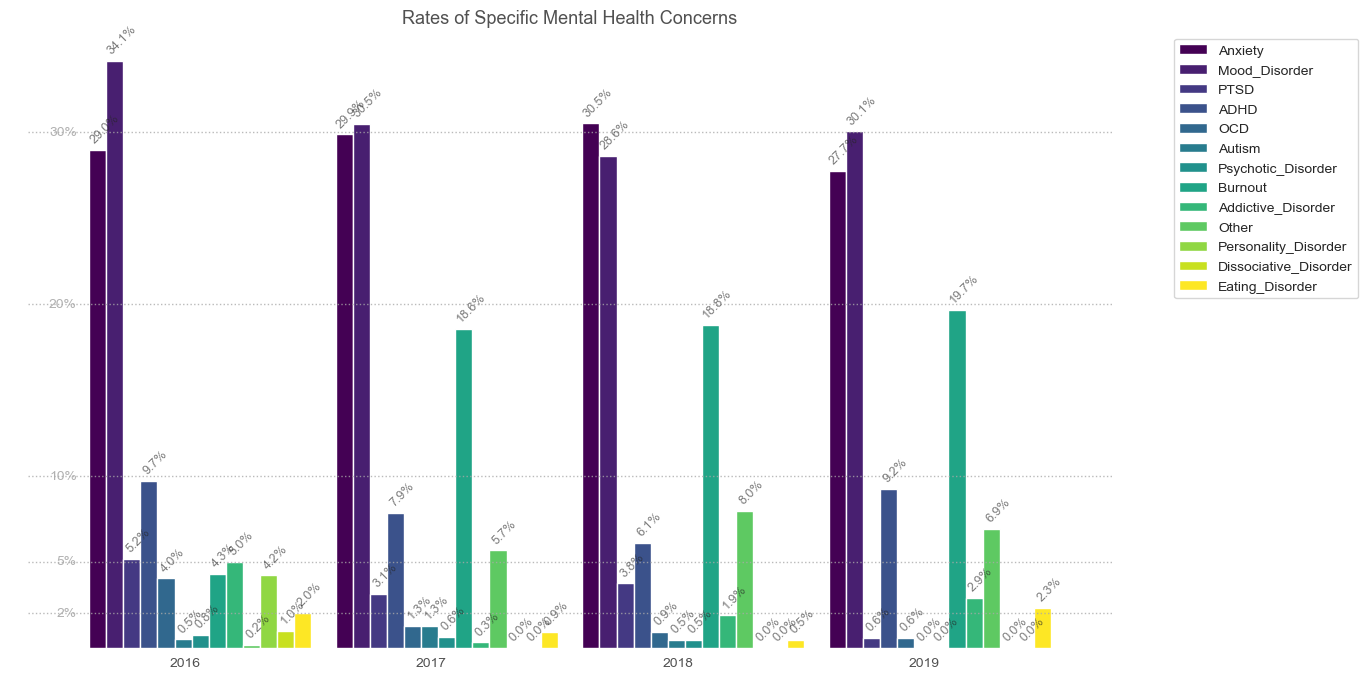

In [30]:
sns.set_style(style="white")

# Calculate the total number of responders for each year
total_responders = df_combined.sum(axis=1)

# Calculate percentages
df_percentage = df_combined.divide(total_responders, axis=0) * 100

# Plotting percentages
plt.figure(figsize=(12, 8))  # Adjust figure size for better layout

# Plot the percentage data as vertical bars
ax = df_percentage.plot(kind='bar', figsize=(14, 8), colormap='viridis', width=0.9)

# Add horizontal lines at 5%, 10%, and 20%
for percentage in [2, 5, 10, 20, 30]:
    plt.axhline(y=percentage, color='darkgray', linestyle='dotted', linewidth=1, alpha=0.8)
    plt.text(x=-0.5, y=percentage, s=f'{percentage}%', color='darkgray', fontsize=10, alpha=0.9, ha='right', va='center')

# Add title and labels
plt.title('Rates of Specific Mental Health Concerns', fontsize=13, alpha=0.8)
plt.xlabel(' ')
plt.ylabel(' ')

# Add annotations for percentages
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    fontsize=9, alpha=0.6, rotation=45,
                    xytext=(5, 3),
                    textcoords="offset points",
                    ha='center',
                    va='bottom')

plt.xticks(rotation=0, ha='right', alpha=0.8)

sns.despine(left=True, bottom=True, right=True, top=True) # Remove spines

plt.gca().tick_params(axis='y', which='both', left=False, labelleft=False)
plt.gca().tick_params(axis='x', which='both', left=False, bottom=False)

# Display the plot
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Adjust the second value in bbox_to_anchor to move legend
plt.show()

It's interesting to see the keyword analysis in 2017-2019 yielding results not too dissimilar from the explicit 2016 responses. "Burnout" notably appears more in the keyword analysis; this makes sense, as "burnout" isn't an explicit mental health diagnosis, though survey participants could select it. 

NIMH has some different categories than this survey. From the categories in common, here are the rates NIMH reports for adults experiencing a particular condition in the past year:

+ Anxiety: 19.1%
+ PTSD: 3.6%
+ ADHD: 4.4%
+ OCD: 1.2%
+ Personality Disorder: 9.1%

Are the differences in rates in the 2016 survey statistically significant?

In [31]:
# Number of bootstrap samples
n_bootstrap_samples = 10000

# NIMH AMI rates
nimh_rates = {
    "Anxiety": 19.1,
    "PTSD": 3.6,
    "ADHD": 4.4,
    "OCD": 1.2,
    "Personality Disorders": 9.1,
}

# Survey data
survey_counts = {
    "Anxiety": 537,
    "PTSD": 96,
    "ADHD": 180,
    "OCD": 75,
    "Personality Disorders": 78,
}
survey_all_total = 1433

def bootstrap_ami_rate(survey_count, survey_total, n_samples=10000):
    """
    Generate a bootstrap distribution for AMI rates.
    
    Parameters:
        survey_count (int): The number of responders reporting the condition.
        survey_total (int): Total number of survey responders.
        n_samples (int): Number of bootstrap samples to generate.
        
    Returns:
        numpy array: Bootstrap distribution of AMI rates.
    """
    # Observed proportion
    observed_rate = survey_count / survey_total
    
    # Bootstrap distribution
    bootstrap_distribution = []
    for _ in range(n_samples):
        # Resample with replacement
        resample = np.random.choice([1, 0], size=survey_total, p=[observed_rate, 1 - observed_rate])
        # Calculate resampled AMI rate
        bootstrap_rate = np.sum(resample) / survey_total
        bootstrap_distribution.append(bootstrap_rate * 100)  # Convert to percentage
    
    return np.array(bootstrap_distribution)

# Generate bootstrap distributions for all conditions
bootstrap_distributions = {
    condition: bootstrap_ami_rate(survey_counts[condition], survey_all_total, n_bootstrap_samples)
    for condition in survey_counts
}

def calculate_p_value(bootstrap_distribution, nimh_rate):
    """
    Calculate the p-value based on a bootstrap distribution and a reference NIMH rate.
    
    Parameters:
        bootstrap_distribution (numpy array): Bootstrap samples.
        nimh_rate (float): Reference NIMH rate for comparison.
    
    Returns:
        float: The calculated p-value.
    """
    # Calculate how many bootstrap samples are less than or greater than the NIMH rate
    above_nimh = np.sum(bootstrap_distribution >= nimh_rate)
    below_nimh = np.sum(bootstrap_distribution <= nimh_rate)
    
    # Two-tailed p-value
    p_value = min(above_nimh, below_nimh) / len(bootstrap_distribution)
    return p_value

# Calculate p-values for each condition
p_values = {
    condition: calculate_p_value(bootstrap_distributions[condition], nimh_rates[condition])
    for condition in nimh_rates
}

# Output the p-values
for condition, p_value in p_values.items():
    print(f"{condition}: p-value = {p_value:.4f}")

Anxiety: p-value = 0.0000
PTSD: p-value = 0.0000
ADHD: p-value = 0.0000
OCD: p-value = 0.0000
Personality Disorders: p-value = 0.0000


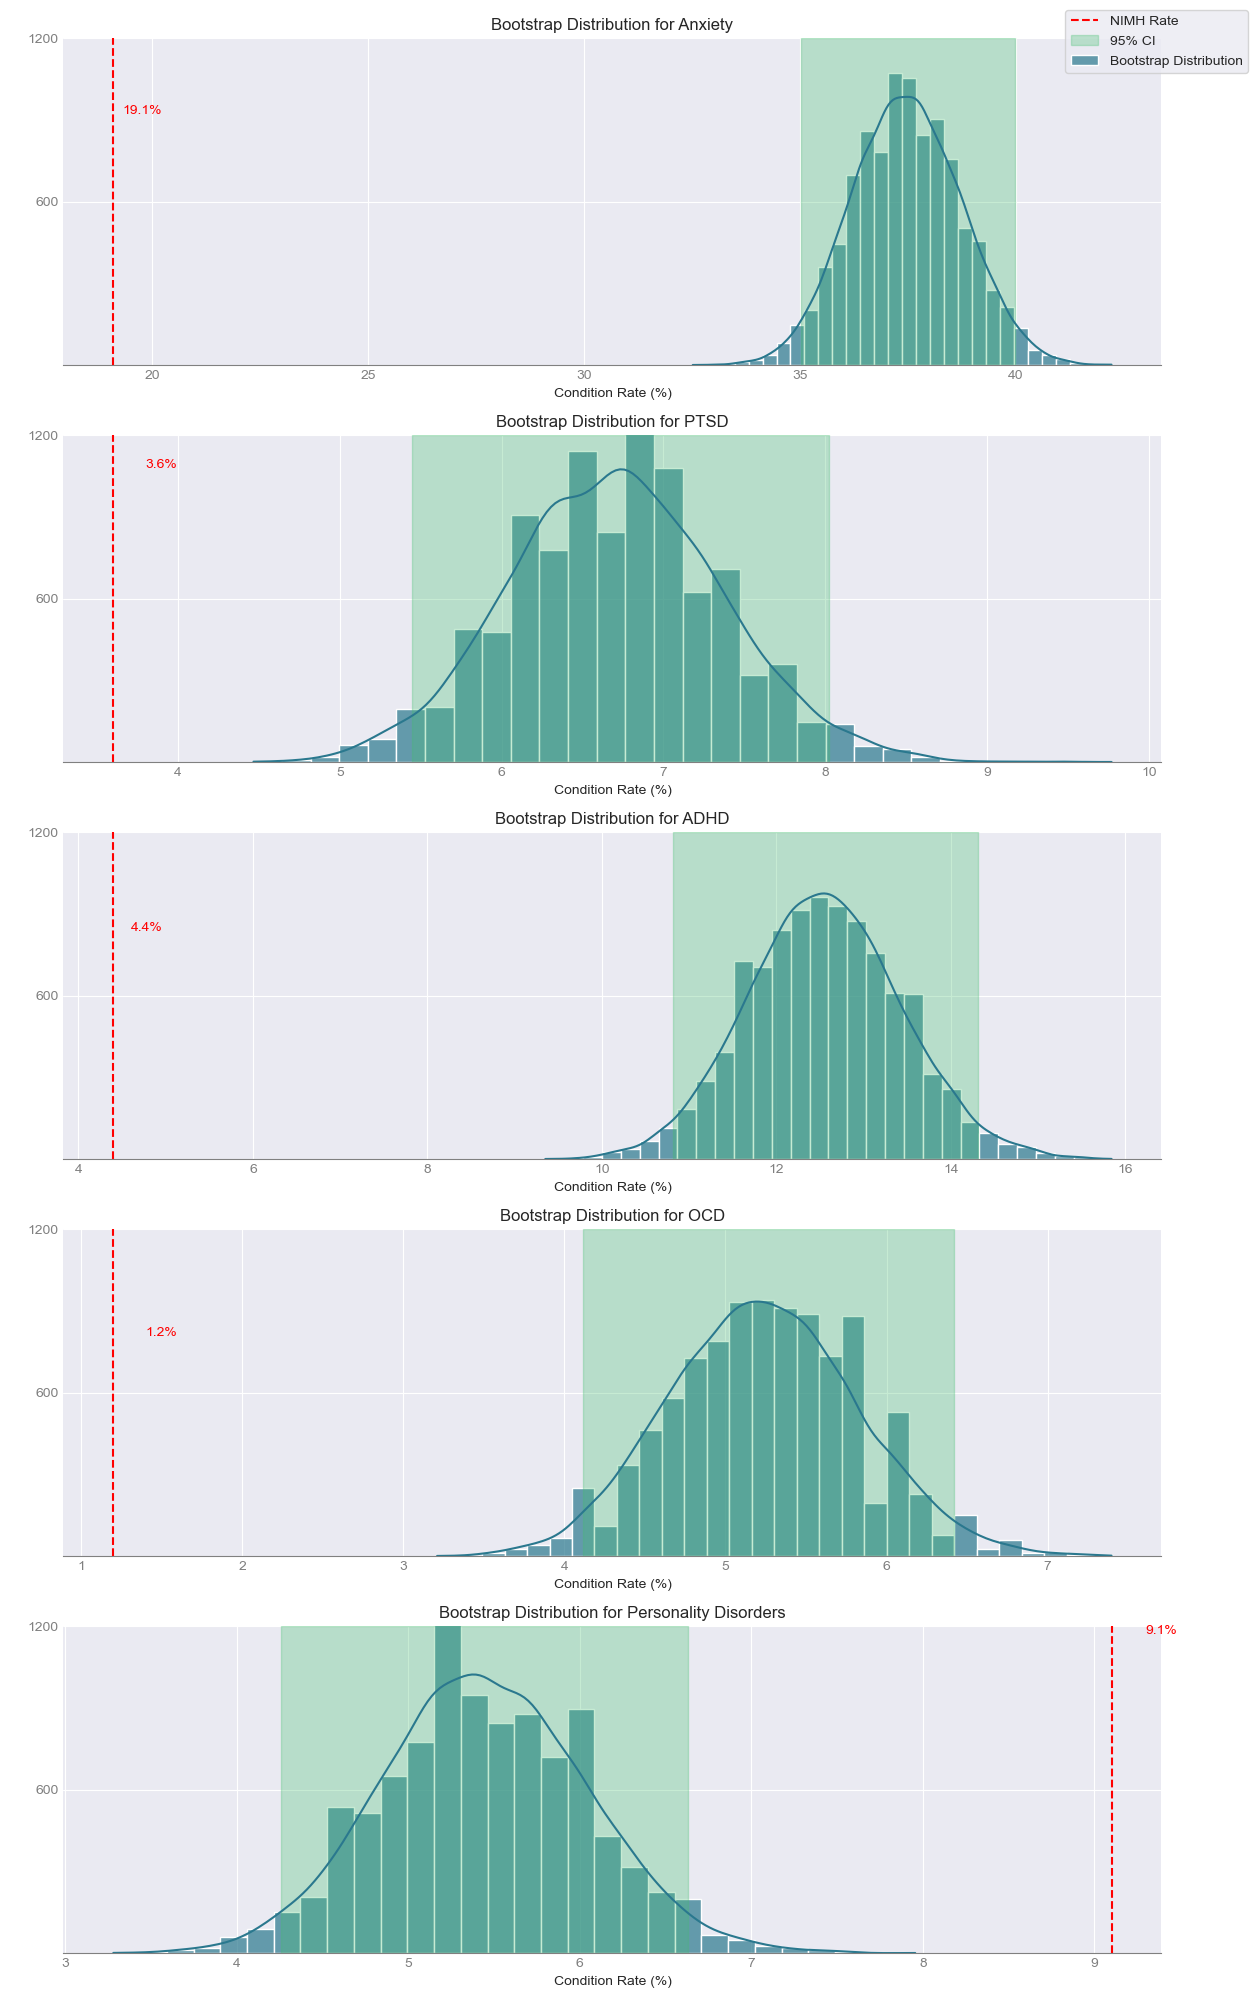

In [32]:
sns.set_style(style='darkgrid')

def plot_bootstrap_distribution(bootstrap_distribution, nimh_rate, condition, ax, colormap):
    """
    Plot the bootstrap distribution with NIMH rate and shaded confidence intervals.
    
    Parameters:
        bootstrap_distribution (array-like): Bootstrap samples.
        nimh_rate (float): Reference NIMH rate for comparison.
        condition (str): The name of the mental health condition.
        ax (matplotlib.axes.Axes): The axes object for the plot.
        colormap (matplotlib.colors.Colormap): Colormap for the plot.
    """
    # Calculate confidence intervals
    ci_lower = np.percentile(bootstrap_distribution, 2.5)
    ci_upper = np.percentile(bootstrap_distribution, 97.5)
    
    # Plot the histogram of the bootstrap distribution
    sns.histplot(bootstrap_distribution, bins=30, kde=True, ax=ax, color=colormap(0.4), alpha=0.7, label=f'Bootstrap distribution {condition}', edgecolor=None)
    
    
    # Plot NIMH rate
    ax.axvline(nimh_rate, color='r', linestyle='--', label=f'NIMH Rate {condition}')

    # Add text label for NIMH rate
    ax.text(
        nimh_rate + 0.2,  # Adjust horizontal position to avoid overlap
        ax.get_ylim()[1] * 0.85,  # Adjust vertical position
        f'{nimh_rate}%',  # Label with the NIMH rate value
        color='r', fontsize=10, verticalalignment='top'
    )

    # Shade the area between the confidence intervals
    ax.fill_betweenx(
        y=[0, 1200],
        x1=ci_lower, x2=ci_upper,
        color=colormap(0.7), alpha=0.3, label=f'95% CI {condition}'
    )

    # Set titles and labels
    ax.set_title(f'Bootstrap Distribution for {condition}')
    ax.set_xlabel('Condition Rate (%)')
    ax.set_ylabel(' ')
    
    # Set y-axis limit to 1200
    ax.set_ylim(0, 1200)

    # Set y-axis ticks to only 0, 600, 1200
    ax.set_yticks([600, 1200])

    ax.spines['bottom'].set_color('gray')
    
    # Set label color to gray
    ax.tick_params(axis='y', length=0, labelcolor='gray')
    ax.tick_params(axis='x', length=0, labelcolor='gray')

# Plotting the distributions for all conditions
fig, axes = plt.subplots(5, 1, figsize=(12, 20))  # Adjusted to 5x1 layout

colormap = plt.cm.viridis

# Plot each condition's bootstrap distribution
plot_bootstrap_distribution(bootstrap_distributions["Anxiety"], nimh_rates["Anxiety"], 'Anxiety', axes[0], colormap)
plot_bootstrap_distribution(bootstrap_distributions["PTSD"], nimh_rates["PTSD"], 'PTSD', axes[1], colormap)
plot_bootstrap_distribution(bootstrap_distributions["ADHD"], nimh_rates["ADHD"], 'ADHD', axes[2], colormap)
plot_bootstrap_distribution(bootstrap_distributions["OCD"], nimh_rates["OCD"], 'OCD', axes[3], colormap)
plot_bootstrap_distribution(bootstrap_distributions["Personality Disorders"], nimh_rates["Personality Disorders"], 'Personality Disorders', axes[4], colormap)

sns.despine(left=True)

# Create one legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
# Shorten the labels for the legend
short_labels = ['NIMH Rate', '95% CI', 'Bootstrap Distribution']
fig.legend(handles, short_labels, loc='upper right', bbox_to_anchor=(1.05, 1), title="")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

For all conditions, there is a statistically significant difference in the 2016 survey rates and the NIMH rates. Survey reponders showed higher rates of anxiety, PTSD, ADHD, and OCD, and lower rates of personality disorders. 

## Conclusions

An age and gender analysis revealed rates of mental illness in tech appear to be higher than nationwide average for the USA. In terms of specific conditions, respondents rated higher on all that could be compared except for personality disorders.

Reasons behind these differences in rates must be complex and multi-faceted. Knowing they exist is the first step to diving deeper in investigation.

Thank you!